# **Análise de Dados Após Respetivo Tratamento**

## Imports

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from pandas import DataFrame
from sklearn.preprocessing import KBinsDiscretizer
import statistics
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# matplotlib inline

## Carregar os Dataset de Treino e de Teste

In [1]:
%run "../datasets/parse.ipynb"
train_df = parse_train("../")

## Aplicar Tratamento de Dados

In [53]:
from pandas import DataFrame

In [73]:
numeric_columns = ['Hora', 'Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)', 'temp','feels_like','temp_min','temp_max','pressure','humidity', 'wind_speed','clouds_all']

categorical_to_numerical = {
    'Injeção na rede (kWh)': {
        'None': 0,
        'Low': 1,
        'Medium': 2,
        'High':3,
        'Very High':4
    }
}

In [55]:
dropped_columns = ['grnd_level','sea_level','dt']

train_df = train_df.drop(dropped_columns, axis=1)
train_df.head()


,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2022-01-01,0,0.0,0.486,0.0,None,local,16.59,16.00,16.21,16.72,1024,65,3.15,,97,overcast clouds
1,2022-01-01,1,0.0,0.429,0.0,None,local,16.59,16.00,16.21,16.72,1024,65,3.14,,58,broken clouds
2,2022-01-01,2,0.0,0.463,0.0,None,local,16.59,16.03,15.67,16.72,1024,66,3.12,,23,few clouds
3,2022-01-01,3,0.0,0.545,0.0,None,local,13.59,12.75,11.61,16.16,1023,67,3.08,,22,few clouds
4,2022-01-01,4,0.0,0.439,0.0,None,local,14.97,14.27,14.72,15.66,1023,67,3.12,,15,few clouds


In [66]:

# noinspection PyPep8Naming
def decision_tree_data_preparation(df: DataFrame) -> DataFrame:

    prep_df= train_df
    ### Converter as features categoricas em numericas
    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['Data'])

    prep_df['Month'] = record_date.month

    prep_df.loc[(prep_df['Hora'] < 6) & (prep_df['Hora'] > 21), 'Injeção na rede (kWh)'] = 0

            

   
    ### Limites superior e inferior (sem outliers) dos diagramas de caixa
    whiskers = []
    for num in numeric_columns:
        Q1 = prep_df[num].quantile(0.25)
        Q3 = prep_df[num].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        whiskers.append((num,lower,upper))

    ### Tratar os outliers das features numéricas:
    ### Substituir os valores dos outliers pela mediana
    for num, lower, upper in whiskers:
        prep_df = prep_df[(prep_df[num] >= lower) & (prep_df[num] <= upper)]

    return prep_df

In [ ]:
prep_df = decision_tree_data_preparation(train_df)

## Exploração dos Dados 

In [ ]:
prep_df.head()


,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,month
0,2022-01-01,0.0,0.0,0.486,0.0,0,local,16.59,16.00,16.21,16.72,1024,65,3.15,,97,overcast clouds,1
1,2022-01-01,1.0,0.0,0.429,0.0,0,local,16.59,16.00,16.21,16.72,1024,65,3.14,,58,broken clouds,1
2,2022-01-01,2.0,0.0,0.463,0.0,0,local,16.59,16.03,15.67,16.72,1024,66,3.12,,23,few clouds,1
3,2022-01-01,3.0,0.0,0.545,0.0,0,local,13.59,12.75,11.61,16.16,1023,67,3.08,,22,few clouds,1
4,2022-01-01,4.0,0.0,0.439,0.0,0,local,14.97,14.27,14.72,15.66,1023,67,3.12,,15,few clouds,1


- Definição do primeiro e do terceiro quartis
- Definição dos valores máximo (*upper*) e mínimo (*lower*)

In [ ]:
numeric_columns = ['Hora', 'Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)', 'temp','feels_like','temp_min','temp_max','pressure','humidity', 'wind_speed','clouds_all']
whiskers = []

for num in numeric_columns:
    Q1 = prep_df[num].quantile(0.25)
    Q3 = prep_df[num].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    whiskers.append((num,lower,upper))

print(whiskers)

[('Hora', -11.5, 34.5), ('Normal (kWh)', -0.28200000000000003, 0.47000000000000003), ('Horário Económico (kWh)', -0.47250000000000003, 0.7875000000000001), ('Autoconsumo (kWh)', -0.301875, 0.503125), ('temp', 1.998750000000002, 21.088749999999997), ('feels_like', 0.02624999999999833, 20.996250000000003), ('temp_min', 0.21999999999999797, 20.220000000000002), ('temp_max', 3.389999999999999, 21.310000000000002), ('pressure', 1003.0, 1043.0), ('humidity', 20.5, 128.5), ('wind_speed', -0.06999999999999962, 4.89), ('clouds_all', -143.0, 241.0)]


## Visualização gráfica dos dados

- Matriz de correlação para valores numéricos

<Axes: >

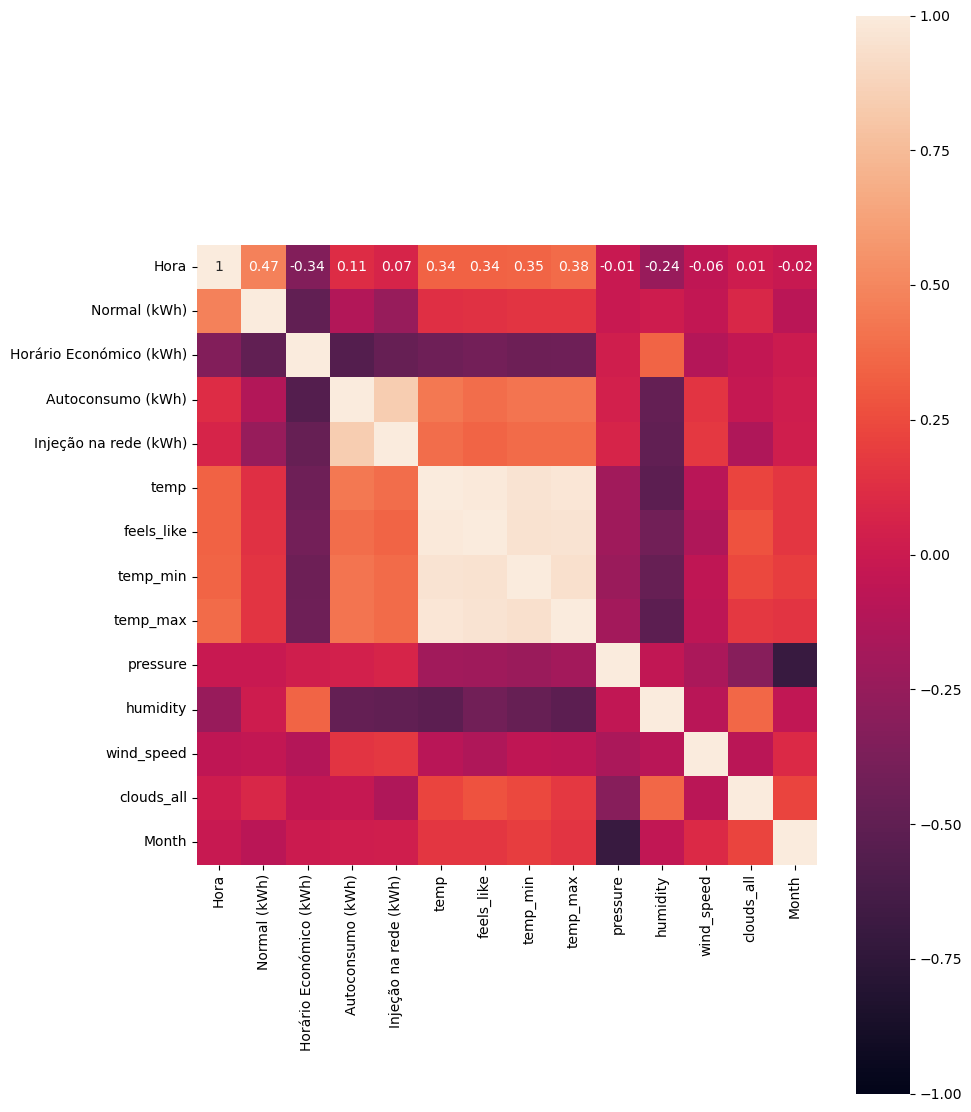

In [64]:
numeric_columns = prep_df.select_dtypes(include=[np.number])
correlationMatrix = numeric_columns.corr().round(2)
f, ax = plt.subplots(figsize=(10, 14))
sns.heatmap(correlationMatrix, vmin=-1, vmax=1, square=True, annot=True)

- Distribuições bivariadas de pares num conjunto de dados

In [70]:
sns.pairplot(prep_df)

c:\Desktop\miniconda3\envs\mypython3version\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Desktop\miniconda3\envs\mypython3version\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Desktop\miniconda3\envs\mypython3version\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Desktop\miniconda3\envs\mypython3version\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

Error in callback <function flush_figures at 0x000001EE3DF67130> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

- Diagrama de caixa para cada feature numérica

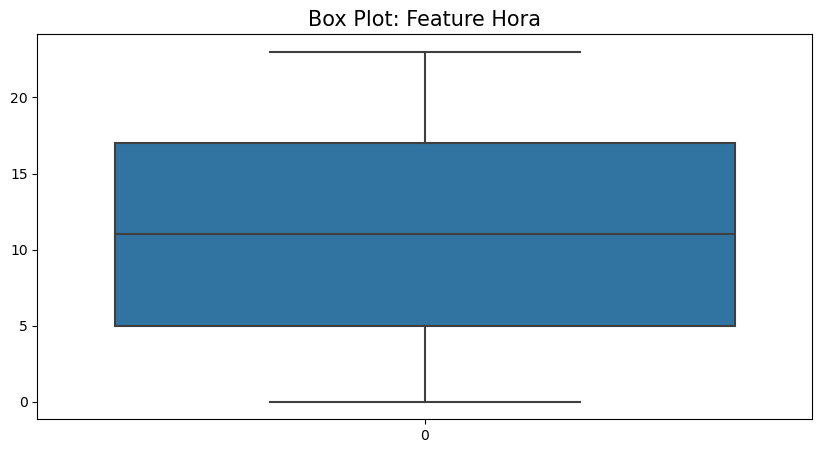

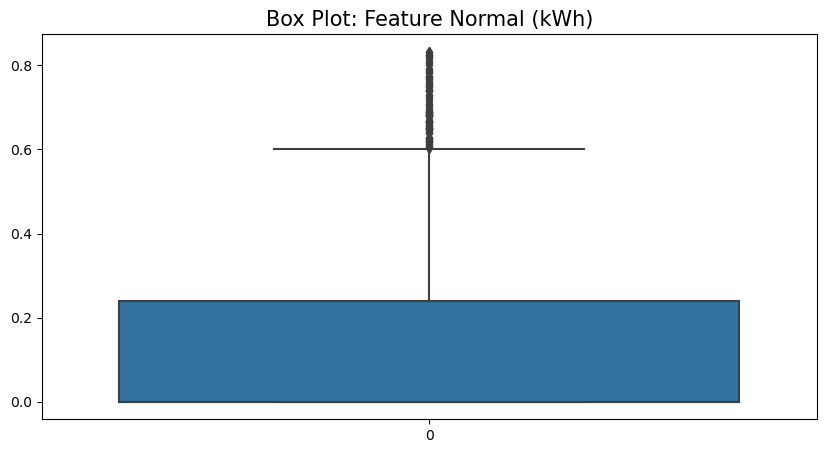

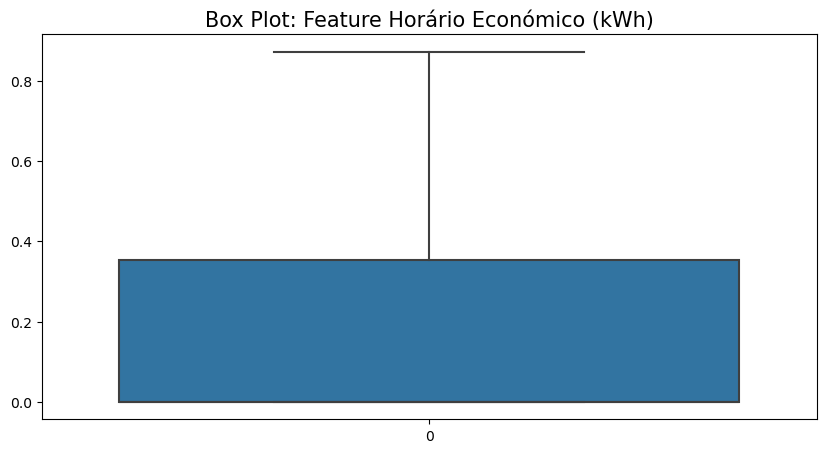

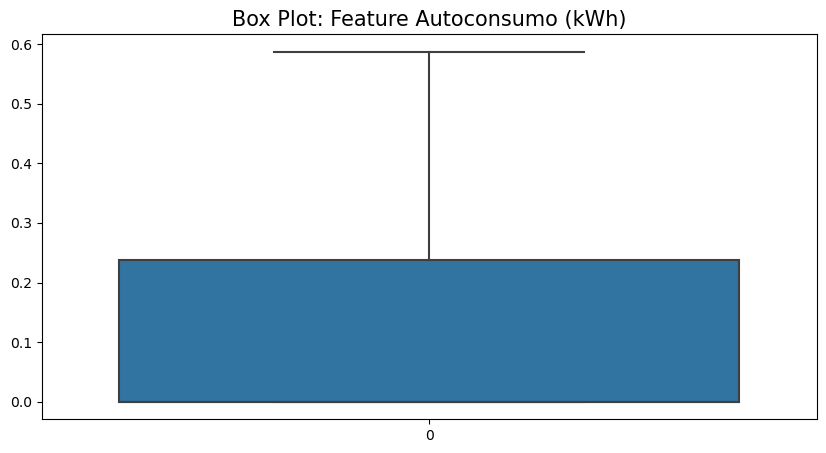

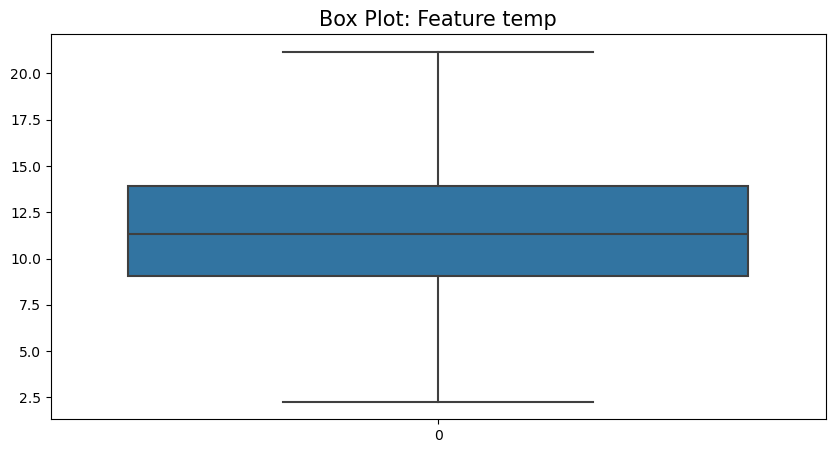

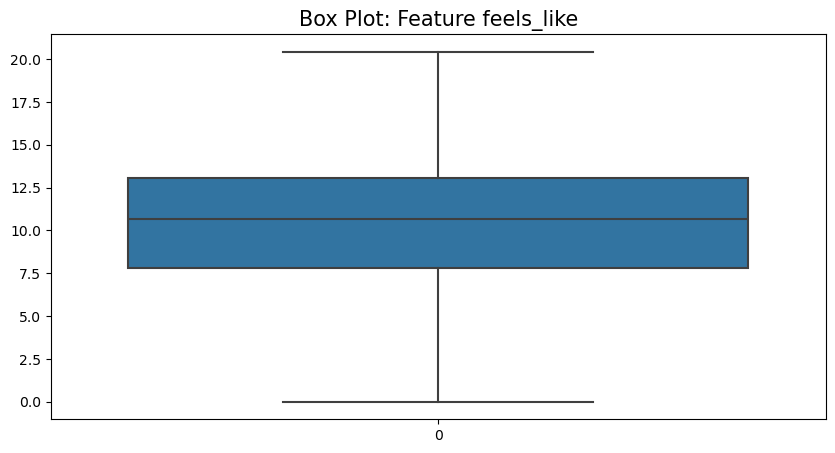

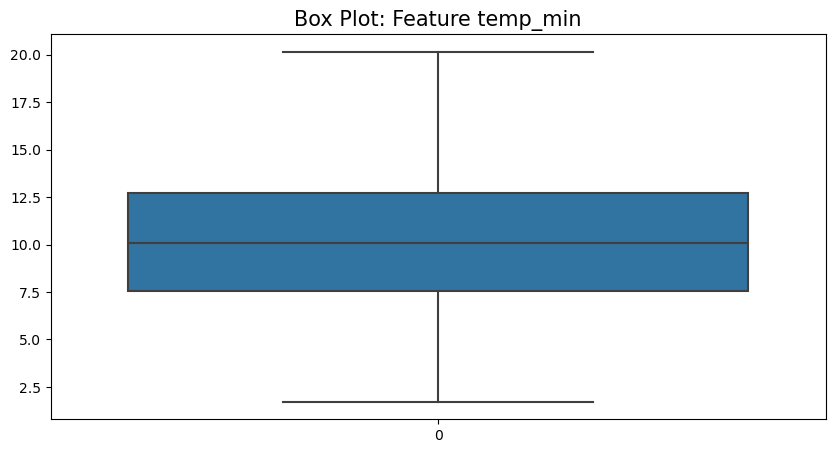

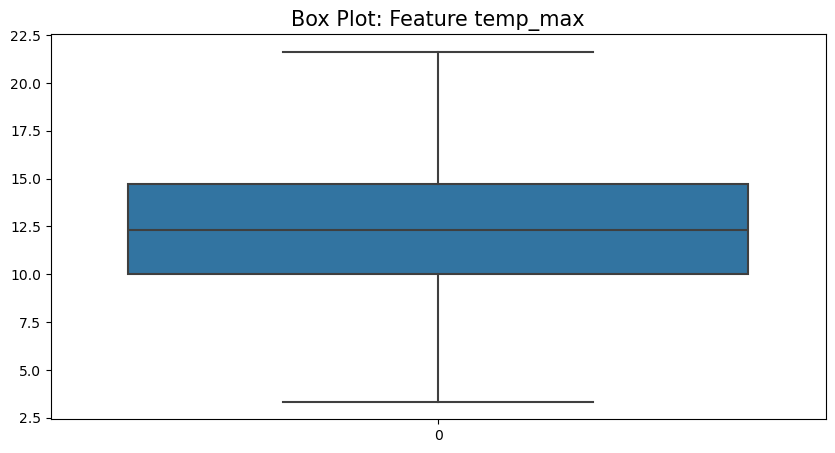

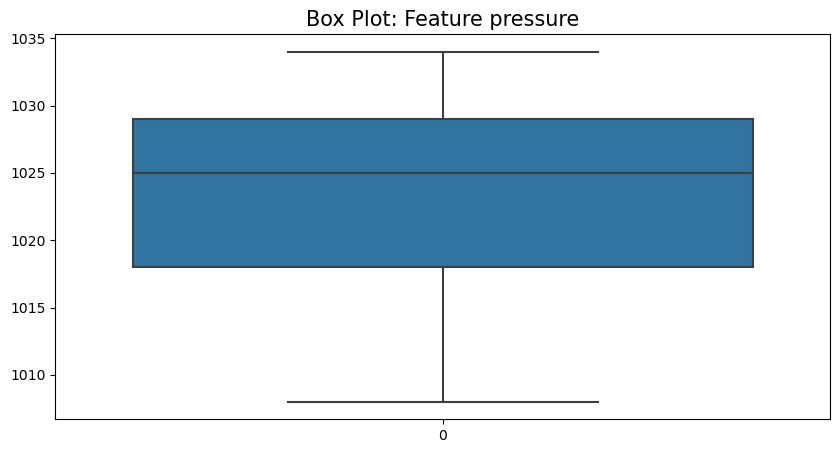

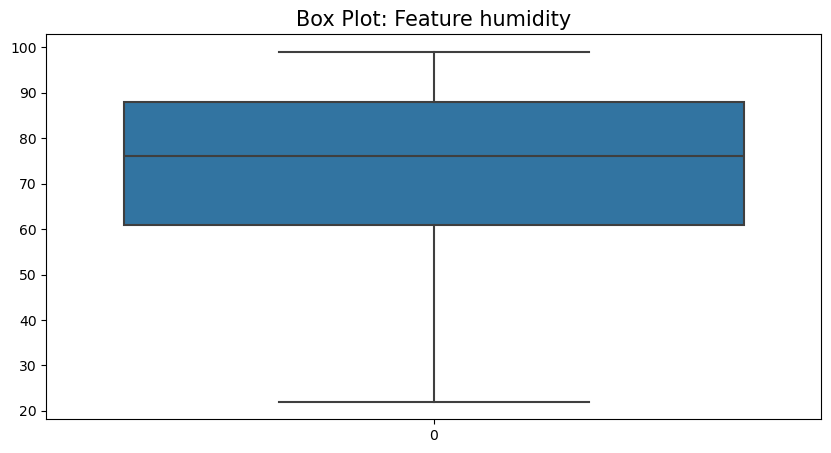

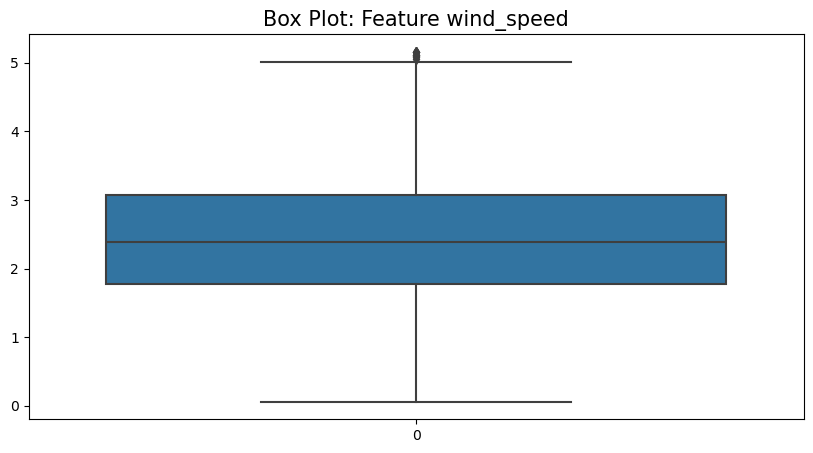

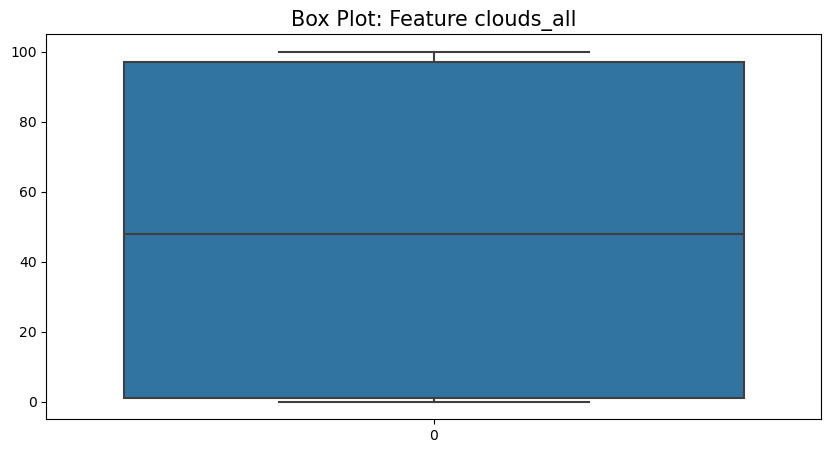

In [74]:
for num in numeric_columns:
    fig = plt.figure(figsize=(10,5))
    sns.boxplot(prep_df[num])
    plt.title('Box Plot: Feature ' + num, fontsize=15)
    plt.show()

- Quantidade de valores nulos em cada feature

<Axes: >

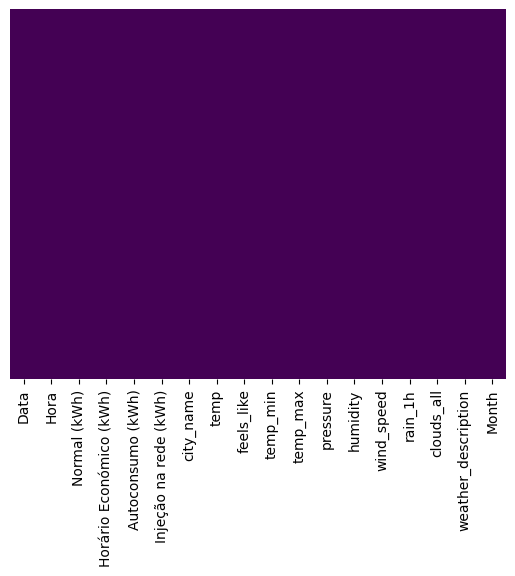

In [75]:
sns.heatmap(prep_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

- Histograma de um conjunto univariante de observações da feature **incidents** (target)

c:\Desktop\miniconda3\envs\mypython3version\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Desktop\miniconda3\envs\mypython3version\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


ValueError: arange: cannot compute length

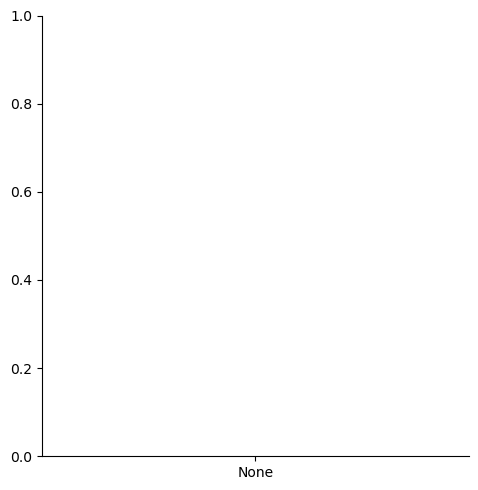

In [86]:
train_df['Injeção na rede (kWh)'].unique()
train_df['Injeção na rede (kWh)'] = pd.Categorical(train_df['Injeção na rede (kWh)'], categories=['None', 'Low', 'Medium', 'High', 'Very High'])
sns.displot(train_df['Injeção na rede (kWh)'], kde=True)

c:\Desktop\miniconda3\envs\mypython3version\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Desktop\miniconda3\envs\mypython3version\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


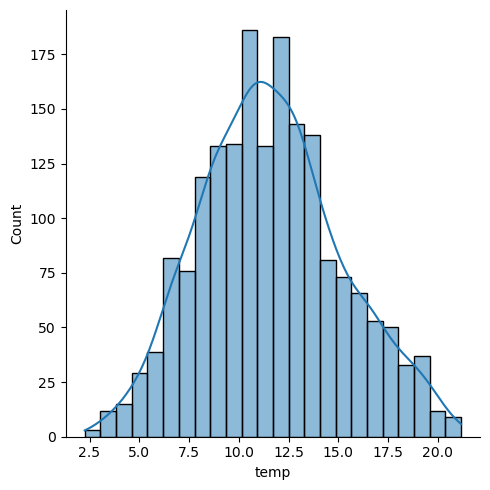

In [88]:
sns.displot(prep_df['temp'], kde=True)